# Computing the Optimal Growth Model by Dynamic Programming

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Computation of the optimal growth model

Let's consider the following optimal growth model again:

$$
\begin{aligned}
	&\max\int_{0}^{\infty}e^{-\rho t}u(c(t))dt \\
	&\text{subject to} \\
	&\qquad\dot{k}(t)=f(k(t))-\delta k(t)-c(t),\\
	&\qquad k(0):\text{ given.} \\
\end{aligned}
$$

We assume that 

$$
\begin{aligned}
   u(c) &= \frac{c^{1-\theta}}{1-\theta}, \quad \theta > 0, \\
   f(k) &= A k^\alpha, \quad 0 < \alpha < 1, \quad A > 0
\end{aligned}
$$

We will use the following parameters.

In [2]:
alpha = 0.3
delta = 0.05
theta = 1
rho = 0.1
A = 1

def u(c):
    """utility function"""
    if theta == 1:
        return np.log(c)
    return c**(1 - theta) / (1 - theta)

def f(k):
    """production function"""
    return A * k**alpha

## Dynamic programing approach

By the method of dynamic programing we know that the value that the objective function attains along the optimal path is a function of initial $k(0) = k$. This function is denoted by 

$$
   v(k)
$$

and is called the value function. It satisfies the following Hamilton-Jacobi-Bellman equation:

$$
   \rho v (k) = \max_c \left[u(c)+v'(k)\left\{ f(k)-\delta k-c\right\} \right], \quad  k \ge 0.
$$


Since the maximizing consumption is attained at

$$
   c(k) = (u')^{-1}(v'(k)), 
$$

having $\max$ in the equation doesn't make things hard. 

Here is a trick to compute $v$ iteratively. Consider the following update rule: 

$$
   \frac{v_1(k) - v_0(k)}{\Delta} + \rho v_0(k) = \max_c \left[u(c)+v'_0(k)\left\{ f(k)-\delta k-c\right\} \right],
$$

where $v_0$ is the current guess of the value and $v_1$ is the updated guess. If you continue this procedure of updating the guess from $v_0$ to $v_1$ and to $v_2, \dots$, until $v_n$ and $v_{n+1}$ are sufficiently close to each other (Technically speaking this is not sufficient for convergence). You will get a good approximation of the true value function $v$.

I will demonstrate this solution method here. You don't have to fully understand the theory at this stage. I adapted the code (for this explicit method) by B. Moll http://www.princeton.edu/~moll/HACTproject/HACT_Additional_Codes.pdf

The below code is not optimized.

In [3]:
dk = 0.01
kgrid = np.arange(0.01, 5, dk)
Delta = 0.2 * dk / max(f(kgrid) - delta * kgrid)

def uprime(c):
    """derivative of u"""
    return c**(-theta)

def uprime_inv(y):
    """inverse of u'"""
    return y**(-1/theta)

def update_value(v):
    """update rule"""
    v1 = np.empty_like(v)
    for i, k in enumerate(kgrid):
        if i == 0:
            vprime = (v[i+1] - v[i]) / dk
        elif i == len(kgrid)-1:
            vprime = (v[i] - v[i-1]) / dk
        else:
            dvf = (v[i+1] - v[i]) / dk
            dvb = (v[i] - v[i-1]) / dk
            dv0 = uprime(f(k) - delta*k)
            
            muf = f(k) - delta*k - uprime_inv(dvf)
            mub = f(k) - delta*k - uprime_inv(dvb)
            
            if muf > 0:
                vprime = dvf
            elif mub < 0:
                vprime = dvb
            else:
                vprime = dv0
        
        c = uprime_inv(vprime)
        v1[i] = v0[i] + Delta * (- rho*v0[i] + u(c) + vprime*(f(k) - delta*k - c))
        
    return v1

The value function is attained after iteration.

In [4]:
v0 = f(kgrid)
for _ in range(3000):
    v1 = update_value(v0)
    if np.sum((v0 - v1)**2) < 1e-5:
        break
    v0 = v1

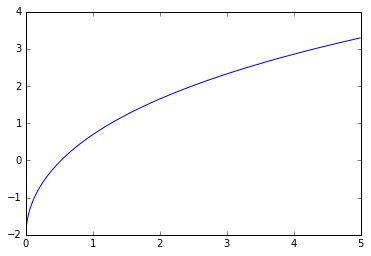

In [5]:
fig, ax = plt.subplots(1,1)
ax.plot(kgrid, v0)

Since you have the value function, it is possible to compute the policy function (or the consumption function) by 

$$
   c(k) = (u')^{-1}(v'(k)),
$$

a (naive) computation of which involves numerical differentiation.

In [6]:
def value_function(k):
    return np.interp(k, kgrid, v0)

def vprime(k, dk=0.001):
    return (value_function(k + dk) - value_function(k)) / dk

In [7]:
def phase_diagram(kmax, gridnum, yamp=1.8, colors=['black', 'black'], labels_on=False):

    kgrid = np.linspace(0.0, kmax, gridnum)

    fig, ax = plt.subplots(1,1)

    # EE locus
    ax.plot(kgrid, f(kgrid) - delta * kgrid, color=colors[0])
    if labels_on:
        ax.text(4, f(4) - delta * 4, '$\dot k = 0$', fontsize=16)

    # CA locus
    kstar = ((delta + rho) / (A * alpha)) ** (1/(alpha - 1))
    ax.axvline(kstar, color=colors[1])
    if labels_on:
        ax.text(kstar*1.01, 0.1, '$\dot c = 0$', fontsize=16)

    # axis labels
    ax.set_xlabel('$k$', fontsize=16)
    ax.set_ylabel('$c$', fontsize=16)
        
    ax.set_ylim([0.0, yamp * np.max(f(kgrid) - delta*kgrid)])

    return fig, ax

/Users/kenjisato/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in reciprocal


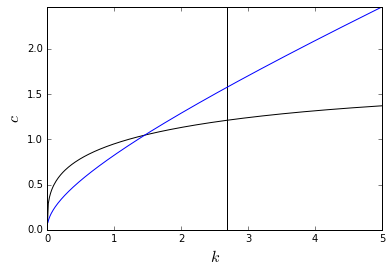

In [8]:
fig, ax = phase_diagram(kmax=5, gridnum=300)
ax.plot(kgrid, uprime_inv(vprime(kgrid)))